# Introduction to Recurrent Neural Networks
(c) Deniz Yuret, 2019
* Objectives: learn about RNNs, the RNN layer, compare with MLP on a tagging task.
* Prerequisites: [MLP models](40.mlp.ipynb)
* New functions: 
[RNN](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.RNN),
[adam](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.adam)

![image](https://github.com/denizyuret/Knet.jl/blob/master/docs/src/images/RNN-unrolled.png?raw=true)([image
source](http://colah.github.io/posts/2015-08-Understanding-LSTMs))

In this notebook we will see how to implement a recurrent neural network (RNN) in Knet. In RNNs, connections between units form a directed cycle, which allows them to keep a persistent state over time. This gives them the ability to process sequences of arbitrary length one element at a time, while keeping track of what happened at previous elements. One can view the current state of the RNN as a representation for the sequence processed so far.

We will build a part-of-speech tagger using a large annotated corpus of English. We will represent words with numeric vectors appropriate as inputs to a neural network. These word vectors will be initialized randomly and learned during training just like other model parameters. We will compare three network architectures: (1) an MLP which tags each word independently of its neighbors, (2) a simple RNN that can represent the neighboring words to the left, (3) a bidirectional RNN that can represent both left and right contexts. As can be expected 1 < 2 < 3 in performance. More surprisingly, the three models are very similar to each other: we will see their model diagrams are identical except for the horizontal connections that carry information across the sequence. 

In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"] = 72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Random: shuffle!
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Knet: Knet, AutoGrad, param, param0, mat, RNN, relu, Data, adam, progress, nll, zeroone

## The Brown Corpus
To introduce recurrent neural networks (RNNs) we will train a part-of-speech tagger using the [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus). We will train three models: a MLP, a unidirectional RNN, a bidirectional RNN and observe significant performance differences.

In [2]:
include(Knet.dir("data/nltk.jl"))
(data,words,tags) = brown()
println("The Brown Corpus has $(length(data)) sentences, $(sum(length(p[1]) for p in data)) tokens, with a word vocabulary of $(length(words)) and a tag vocabulary of $(length(tags)).")

┌ Info: Recompiling stale cache file /kuacc/users/dyuret/.julia/compiled/v1.1/ZipFile/cOum2.ji for ZipFile [a5390f91-8eb1-5f08-bee0-b1d1ffed6cea]
└ @ Base loading.jl:1184


The Brown Corpus has 57340 sentences, 1161192 tokens, with a word vocabulary of 56057 and a tag vocabulary of 472.


`data` is an array of `(w,t)` pairs each representing a sentence, where `w` is a sequence of word ids, and `t` is a sequence of tag ids. `words` and `tags` contain the strings for the ids. 

In [3]:
println.(summary.((data,words,tags)));

57340-element Array{Tuple{Array{UInt16,1},Array{UInt16,1}},1}
56057-element Array{String,1}
472-element Array{String,1}


Here is what the first sentence looks like with ids and with strings:

In [4]:
(w,t) = first(data)
display(permutedims(Int[w t]))
display(permutedims([words[w] tags[t]]))

2×25 Array{Int64,2}:
 15  5860  1296  5597  17468  60  …  14   9  85  10004  221  189  3
  3    40    21    39     21  13     29  14  46      7   13    1  5

2×25 Array{String,2}:
 "The"  "Fulton"  "County"  "Grand"  "Jury"   …  "took"  "place"  "."
 "at"   "np-tl"   "nn-tl"   "jj-tl"  "nn-tl"     "vbd"   "nn"     "."

## Chain of layers

In [5]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)

## Dense layers

In [6]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

## Word Embeddings
`data` has each sentence tokenized into an array of words and each word mapped to a `UInt16` id. To use these words as inputs to a neural network we further map each word to a Float32 vector. We will keep these vectors in the columns of a size (X,V) matrix where X is the embedding dimension and V is the vocabulary size. The vectors will be initialized randomly, and trained just like any other network parameter. Let's define an embedding layer for this purpose:

In [7]:
struct Embed; w; end
Embed(vocabsize::Int,embedsize::Int) = Embed(param(embedsize,vocabsize))
(e::Embed)(x) = e.w[:,x]

This is what the words, word ids and embeddings for a sentence looks like: (note the identical id and embedding for the 2nd and 5th words)

In [8]:
embedlayer = Embed(length(words),8)
(w,t) = data[52855]
display(permutedims(words[w]))
display(permutedims(Int.(w)))
display(embedlayer(w))

1×7 Array{String,2}:
 "Rapping"  "the"  "stick"  "against"  "the"  "desk"  "."

1×7 Array{Int64,2}:
 47900  1  3014  163  1  1719  3

8×7 Knet.KnetArray{Float32,2}:
  0.00434508  -0.00492594   …   0.000365941   0.00310567
 -0.00287003   0.00497193      -0.00260259   -0.00419249
 -0.00293572  -0.00468493       0.000826253  -0.00481489
 -0.00133833   0.000289347     -0.00566444    0.00222202
  0.00378727  -0.00323536      -0.000665534  -0.00244028
 -0.00178806  -0.00562227   …  -0.00285093    0.00400103
 -0.00105484  -0.00400417      -0.00488922   -0.0014784 
 -0.00103929   0.00530739      -0.00370049   -0.00561701

## RNN layers

In [9]:
@doc RNN

```
rnn = RNN(inputSize, hiddenSize; opts...)
rnn(x; batchSizes) => y
rnn.h, rnn.c  # hidden and cell states
```

`RNN` returns a callable RNN object `rnn`. Given a minibatch of sequences `x`, `rnn(x)` returns `y`, the hidden states of the final layer for each time step. `rnn.h` and `rnn.c` fields can be used to set the initial hidden states and read the final hidden states of all layers.  Note that the final time step of `y` always contains the final hidden state of the last layer, equivalent to `rnn.h` for a single layer network.

**Dimensions:** The input `x` can be 1, 2, or 3 dimensional and `y` will have the same number of dimensions as `x`. size(x)=(X,[B,T]) and size(y)=(H/2H,[B,T]) where X is inputSize, B is batchSize, T is seqLength, H is hiddenSize, 2H is for bidirectional RNNs. By default a 1-D `x` represents a single instance for a single time step, a 2-D `x` represents a single minibatch for a single time step, and a 3-D `x` represents a sequence of identically sized minibatches for multiple time steps. The output `y` gives the hidden state (of the final layer for multi-layer RNNs) for each time step. The fields `rnn.h` and `rnn.c` represent the hidden states of all layers in a single time step and have size (H,B,L/2L) where L is numLayers and 2L is for bidirectional RNNs.

**batchSizes:** If `batchSizes=nothing` (default), all sequences in a minibatch are assumed to be the same length. If `batchSizes` is an array of (non-increasing) integers, it gives us the batch size for each time step (allowing different sequences in the minibatch to have different lengths). In this case `x` will typically be 2-D with the second dimension representing variable size batches for time steps. If `batchSizes` is used, `sum(batchSizes)` should equal `length(x) ÷ size(x,1)`. When the batch size is different in every time step, hidden states will have size (H,B,L/2L) where B is always the size of the first (largest) minibatch.

**Hidden states:** The hidden and cell states are kept in `rnn.h` and `rnn.c` fields (the cell state is only used by LSTM). They can be initialized during construction using the `h` and `c` keyword arguments, or modified later by direct assignment. Valid values are `nothing` (default), `0`, or an array of the right type and size possibly wrapped in a `Param`. If the value is `nothing` the initial state is assumed to be zero and the final state is discarded keeping the value `nothing`. If the value is `0` the initial state is assumed to be zero and `0` is replaced by the final state on return. If the value is a valid state, it is used as the initial state and is replaced by the final state on return.

In a differentiation context the returned final hidden states will be wrapped in `Result` types. This is necessary if the same RNN object is to be called multiple times in a single iteration. Between iterations (i.e. after diff/update) the hidden states need to be unboxed with e.g. `rnn.h = value(rnn.h)` to prevent spurious dependencies. This happens automatically during the backward pass for GPU RNNs but needs to be done manually for CPU RNNs. See the [CharLM Tutorial](https://github.com/denizyuret/Knet.jl/blob/master/tutorial/80.charlm.ipynb) for an example.

**Keyword arguments for RNN:**

  * `h=nothing`: Initial hidden state.
  * `c=nothing`: Initial cell state.
  * `rnnType=:lstm` Type of RNN: One of :relu, :tanh, :lstm, :gru.
  * `numLayers=1`: Number of RNN layers.
  * `bidirectional=false`: Create a bidirectional RNN if `true`.
  * `dropout=0`: Dropout probability. Applied to input and between layers.
  * `skipInput=false`: Do not multiply the input with a matrix if `true`.
  * `dataType=Float32`: Data type to use for weights.
  * `algo=0`: Algorithm to use, see CUDNN docs for details.
  * `seed=0`: Random number seed for dropout. Uses `time()` if 0.
  * `winit=xavier`: Weight initialization method for matrices.
  * `binit=zeros`: Weight initialization method for bias vectors.
  * `usegpu=(gpu()>=0)`: GPU used by default if one exists.

**Formulas:** RNNs compute the output h[t] for a given iteration from the recurrent input h[t-1] and the previous layer input x[t] given matrices W, R and biases bW, bR from the following equations:

`:relu` and `:tanh`: Single gate RNN with activation function f:

```
h[t] = f(W * x[t] .+ R * h[t-1] .+ bW .+ bR)
```

`:gru`: Gated recurrent unit:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
r[t] = sigm(Wr * x[t] .+ Rr * h[t-1] .+ bWr .+ bRr) # reset gate
n[t] = tanh(Wn * x[t] .+ r[t] .* (Rn * h[t-1] .+ bRn) .+ bWn) # new gate
h[t] = (1 - i[t]) .* n[t] .+ i[t] .* h[t-1]
```

`:lstm`: Long short term memory unit with no peephole connections:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
f[t] = sigm(Wf * x[t] .+ Rf * h[t-1] .+ bWf .+ bRf) # forget gate
o[t] = sigm(Wo * x[t] .+ Ro * h[t-1] .+ bWo .+ bRo) # output gate
n[t] = tanh(Wn * x[t] .+ Rn * h[t-1] .+ bWn .+ bRn) # new gate
c[t] = f[t] .* c[t-1] .+ i[t] .* n[t]               # cell output
h[t] = o[t] .* tanh(c[t])
```


## The three taggers: MLP, RNN, biRNN

## Tagger0 (MLP)
This is what Tagger0 looks like. Every tag is predicted independently. The prediction of each tag only depends on the corresponding word.
<img src="https://docs.google.com/drawings/d/e/2PACX-1vTfV4-TB0KwjDbFKpj3rL0tfeApEh9XXaDJ1OF3emNVAmc_-hvgqpEBuA_K0FsNuxymZrv3ztScXxqF/pub?w=378&h=336"/>

## Tagger1 (RNN) 
In Tagger1, the RNN layer takes its previous output as an additional input. The prediction of each tag is based on words to the left.
<img src="https://docs.google.com/drawings/d/e/2PACX-1vTaizzCISuSxihPCjndr7xMVwklsrefi9zn7ZArCvsR8fb5V4DGKtusyIzn3Ujp3QbAJgUz1WSlLvIJ/pub?w=548&h=339"/>

## Tagger2 (biRNN)
In Tagger2 there are two RNNs: the forward RNN reads the sequence from left to right, the backward RNN reads it from right to left. The prediction of each tag is dependent on all the words in the sentence.
<img src="https://docs.google.com/drawings/d/e/2PACX-1vQawvnCj6odRF2oakF_TgXd8gLxSsfQP8-2ZdBdEIpfgIyPq0Zp_EF6zcFJf6JlGhfiKQvdVyg-Weq2/pub?w=566&h=335"/>

In [10]:
Tagger0(vocab,embed,hidden,output)=  # MLP Tagger
    Chain(Embed(vocab,embed),Dense(embed,hidden,relu),Dense(hidden,output))
Tagger1(vocab,embed,hidden,output)=  # RNN Tagger
    Chain(Embed(vocab,embed),RNN(embed,hidden,rnnType=:relu),Dense(hidden,output))
Tagger2(vocab,embed,hidden,output)=  # biRNN Tagger
    Chain(Embed(vocab,embed),RNN(embed,hidden,rnnType=:relu,bidirectional=true),Dense(2hidden,output));

## Sequence Minibatching
Minibatching is a bit more complicated with sequences compared to simple classification problems, this section can be skipped on a first reading. In addition to the input and minibatch sizes, there is also the time dimension to consider. To keep things simple we will concatenate all sentences into one big sequence, then split this sequence into equal sized chunks. The input to the tagger will be size (B,T) where B is the minibatch size, and T is the chunk size. The input to the RNN layer will be size (X,B,T) where X is the embedding size.

In [11]:
BATCHSIZE = 64
SEQLENGTH = 32;

In [12]:
function seqbatch(x,y,B,T)
    N = length(x) ÷ B
    x = permutedims(reshape(x[1:N*B],N,B))
    y = permutedims(reshape(y[1:N*B],N,B))
    d = []; for i in 0:T:N-T
        push!(d, (x[:,i+1:i+T], y[:,i+1:i+T]))
    end
    return d
end
allw = vcat((x->x[1]).(data)...)
allt = vcat((x->x[2]).(data)...)
d = seqbatch(allw, allt, BATCHSIZE, SEQLENGTH);

This may be a bit more clear if we look at an example minibatch:

In [13]:
(x,y) = first(d)
words[x]

64×32 Array{String,2}:
 "The"              "Fulton"    …  "term-end"     "presentments" 
 "director"         "of"           "gifts"        "from"         
 "local"            "club"         "who"          "will"         
 "."                "The"          "of"           "the"          
 "plans"            "titled"       "this"         "fall"         
 "admitted"         "for"       …  "''"           "."            
 "American"         "system"       "patriotic"    "apprehensions"
 "of"               "the"          "Then"         "cometh"       
 "the"              "misdeeds"     "is"           "entitled"     
 "entertaining"     "and"          "from"         "these"        
 "is"               "merely"    …  "to"           "the"          
 "is"               "not"          "that"         "any"          
 "has"              "said"         "important"    "that"         
 ⋮                              ⋱  ⋮                             
 "."                "But"          "would"        "I"

## Embedding a minibatch
Julia indexing allows us to get the embeddings for this minibatch in one go as an (X,B,T) array where X is the embedding size, B is the minibatch size, and T is the subsequence length.

In [14]:
embedlayer = Embed(length(words),128)
summary(embedlayer(x))

"128×64×32 Knet.KnetArray{Float32,3}"

## Experiments

In [15]:
# shuffle and split minibatches into train and test portions
shuffle!(d)
dtst = d[1:10]
dtrn = d[11:end]
length.((dtrn,dtst))

(556, 10)

In [16]:
# For running experiments we will use the Adam algorithm which typically converges faster than SGD.
function trainresults(file,maker,savemodel)
    if (print("Train from scratch? "); readline()[1]=='y')
        model = maker()
        results = ((nll(model,dtst), zeroone(model,dtst))
                   for x in takenth(progress(adam(model,ncycle(dtrn,5))),100))
        results = reshape(collect(Float32,flatten(results)),(2,:))
        Knet.save(file,"model",(savemodel ? model : nothing),"results",results)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        model,results = Knet.load(file,"model","results")
    end
    println(minimum(results,dims=2))
    return model,results
end

trainresults (generic function with 1 method)

In [17]:
VOCABSIZE = length(words)
EMBEDSIZE = 128
HIDDENSIZE = 128
OUTPUTSIZE = length(tags);

In [18]:
# 2.35e-01  100.00%┣┫ 2780/2780 [00:13/00:13, 216.36i/s] [0.295007; 0.0972656]
t0maker() = Tagger0(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
(t0,r0) = trainresults("tagger134a.jld2",t0maker,false);

Train from scratch? stdin> y
2.43e-01  100.00%┣██████████████████▉┫ 2780/2780 [00:22/00:22, 124.13i/s]
Float32[0.314115; 0.0971191]


In [19]:
# 1.49e-01  100.00%┣┫ 2780/2780 [00:19/00:19, 142.58i/s] [0.21358; 0.0616211]
t1maker() = Tagger1(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
(t1,r1) = trainresults("tagger134b.jld2",t1maker,false);

Train from scratch? stdin> y
1.28e-01  100.00%┣██████████████████▉┫ 2780/2780 [00:21/00:21, 135.36i/s]
Float32[0.236899; 0.0675781]


In [20]:
# 9.37e-02  100.00%┣┫ 2780/2780 [00:25/00:25, 109.77i/s] [0.156669; 0.044043]
t2maker() = Tagger2(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
(t2,r2) = trainresults("tagger134c.jld2",t2maker,true);

Train from scratch? stdin> y
6.52e-02  100.00%┣██████████████████▉┫ 2780/2780 [00:23/00:23, 123.04i/s]
Float32[0.172464; 0.0470703]


In [21]:
using Plots; default(fmt=:png,ls=:auto,ymirror=true)

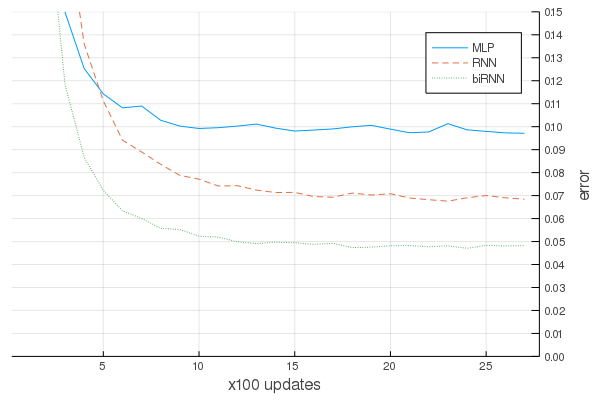

In [22]:
plot([r0[2,:], r1[2,:], r2[2,:]]; xlabel="x100 updates", ylabel="error",
    ylim=(0,0.15), yticks=0:0.01:0.15, labels=["MLP","RNN","biRNN"])

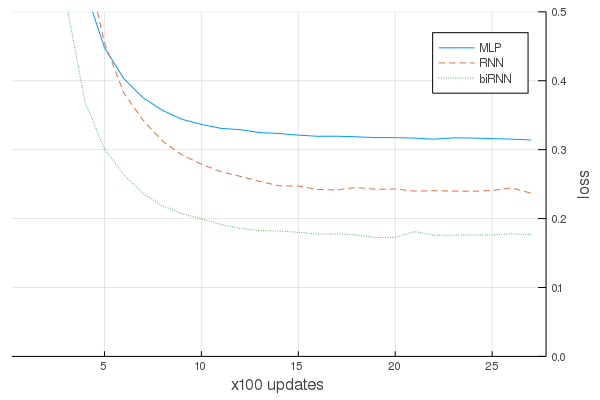

In [23]:
plot([r0[1,:], r1[1,:], r2[1,:]]; xlabel="x100 updates", ylabel="loss",
    ylim=(0,.5), yticks=0:0.1:.5, labels=["MLP","RNN","biRNN"])

## Playground
Below, you can type and tag your own sentences:

In [24]:
wdict=Dict{String,UInt16}(); for (i,w) in enumerate(words); wdict[w]=i; end
unk = UInt16(length(words))
wid(w) = get(wdict,w,unk)
function tag(tagger,s::String)
    w = permutedims(split(s))
    t = tags[(x->x[1]).(argmax(Array(tagger(wid.(w))),dims=1))]
    vcat(w,t)
end

tag (generic function with 1 method)

In [25]:
tag(t2,readline())

stdin> colorless green ideas sleep furiously


2×5 Array{AbstractString,2}:
 "colorless"  "green"  "ideas"  "sleep"  "furiously"
 "jj"         "jj"     "nns"    "vb"     "rb"       